# Commment
- 第二问和第三问的计算结果呢？ 
已添加
- 图中不同颜色的曲线需要使用TLegend做区别。
已添加
- In[4]中有没有更好的办法读入文件，而不是写多个else，如果叫你做所有核素的程序怎么办？ 
已修改
- In[5]中步长选取是否合理？
选取的步长偏大，改小会拖慢运行速度，但是我觉得变步长貌似不太可行

# comment
- 代码运行速度如何？优化好的运行时间应该在20s以内，把部分结果存储再继续运算是合理的处理方式，也可以按照你说的存在root文件里面，连续写的程序嵌套极大的拖慢了运行的速度。（已经写出新的文件new_tele存在目录下）
- 注意代码的缩进、对齐格式的统一。（复制粘贴的时候出现的😂，以后会注意）
- 多次调用读文件的程序很容易挤爆内存，在子程序中设置的new class需要在使用完后delete。
- TH2目前选取的bin宽画出来的图明显清晰度不够。
- 粒子种类也应该使用随机数产生
- 程序中存在大量重复的内容，可以使用循环或者数组的方法优化代码（在新程序中优化了）
- 随机选取粒子数个数的理由是什么？（还没思考好）

In [1]:
//%jsroot on

<font size = 4 >验证He的三个同位素在单位核子能量相同时，能损曲线是否重合。运行结果表明三条曲线基本重合。

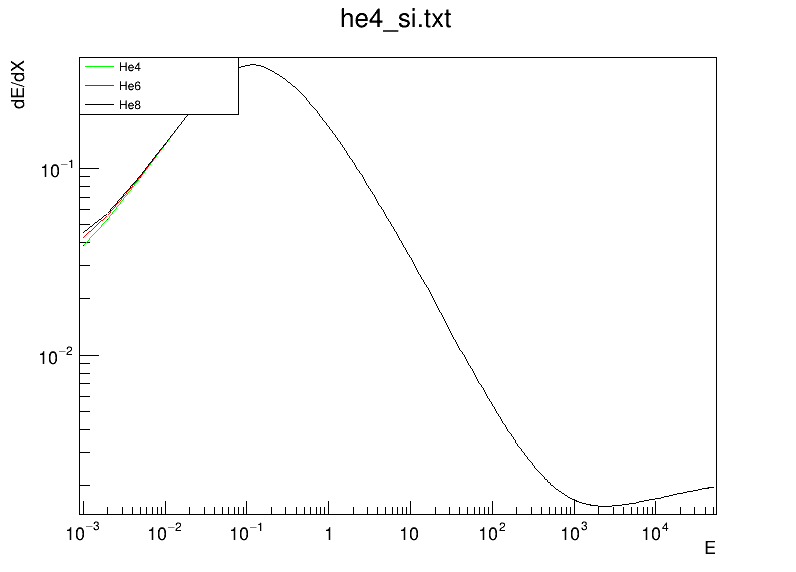

In [2]:
//从Lise产生的文件取数    
TGraph *he4_de = new TGraph("he4_si.txt");
TGraph *he6_de = new TGraph("he6_si.txt");
TGraph *he8_de = new TGraph("he8_si.txt");

TCanvas *c1 = new TCanvas("c1", " ", 800, 600);

//对三个曲线分别绘制
he4_de->SetLineColor(kGreen);
he4_de->GetXaxis()->SetTitle("E");
he4_de->GetYaxis()->SetTitle("dE/dX");
he4_de->Draw();

he6_de->SetLineColor(kRed);
he6_de->Draw("same");

he8_de->SetLineColor(kBlack);
he8_de->Draw("same");

//添加图例
TLegend *legend = new TLegend(0.1, 0.8, 0.3, 0.9);
legend->AddEntry(he4_de, "He4", "l");
legend->AddEntry(he6_de, "He6", "l");
legend->AddEntry(he8_de, "He8", "l");
legend->Draw();

c1->SetLogx();
c1->SetLogy();

c1->Draw();

<font size = 4>可以看到，he的同位素在单位核子能量相同时的曲线只在能量极低时有分别，其余部分重合得非常好

# 定义取数获得的Graph

In [3]:
TGraph* getdedx(string filename, int A){

    ifstream in(filename);

    auto *g = new TGraph;
    string s;
    double e, dedx;

    getline(in, s);
    int i = 0;

    while(!in.eof()){

        in >> e >> dedx;
        getline(in, s);
        if(in.eof()) break;//避免最后一个重复读取

        g->SetPoint(i++, e*A, dedx);//将数据填入创建的Graph，这里的de/dx单位为Mev/微米
    }

    in.close();
    return g;
}

# 封装计算能损本领的函数

In [4]:
double Z_1_8_dedx(string element, int A, double E){//设置输入量，element为元素名称
    
    string a = "./data/";
    string b = "_si.txt";
    string c = a + element + b ;
    double dedx;  

    TGraph *z1 = getdedx(c, A);
    dedx = z1->Eval(E, 0, "S");
    

    
    return dedx;//返回能量损失本领

}

# 封装计算粒子射程的函数
<font size = 4>首先对返回E-x曲线和x-E曲线的Graph进行定义，然后利用这个Graph对粒子入射的距离进行计算

In [5]:
TGraph *ex_gra(string element, int A, int choose){//设置输入量，其中choose的作用是标记返回的曲线类型

    auto *graph1 = new TGraph;
    auto *graph2 = new TGraph;
    int n = 1e8;
    double E_init = 1000., x = 0.;//设置能量初值，和位置初值

    for (int i = 0; i < n; i++){

        E_init = E_init - 100*Z_1_8_dedx(element, A, E_init);//通过迭代求出能量为0时的射程
        x = x + 0.1;
        
        //将数据填入Graph
        graph1->SetPoint(i, E_init, x);
        graph2->SetPoint(i, x, E_init);

        if (E_init < 0) break;
    }

    if (choose == 0) return graph1;//如果choose选择0，则返回E-x曲线
    else if (choose == 1) return graph2;//如果choose选择1，则返回x-E曲线
    else {
        return graph1;
        cout << "plz enter choose 1 or 0" << endl;
    }
}


In [6]:
double range_fun(string element, int A, double E, TGraph *g_range_fun) {
    
    //if(Z > 8 || Z < 1 || Z > A) cout << "Plz enter right Z and A" << endl;

    TGraph *ele = g_range_fun;
   
    return (ele->Eval(0, 0, "S"))-(ele->Eval(E, 0, "S"));//通过E=0时对应的x值减去输入E对应的x值即为射程

}

<font size = 4> 对不同能量不同类别核子的射程进行输出

In [7]:
cout << "能量分别为10MeV,100MeV,200MeV的He4的射程(单位mm)" << range_fun("he", 4, 10, ex_gra("he", 4, 0)) << "  " << range_fun("he", 4, 100, ex_gra("he", 4, 0)) << "  " << range_fun("he", 4, 200, ex_gra("he", 4, 0)) << endl;
cout << "能量分别为10MeV,100MeV,200MeV的C12的射程(单位mm)" << range_fun("c", 12, 10, ex_gra("c", 12, 0)) << "  " << range_fun("c", 12, 100, ex_gra("c", 12, 0)) << "  " << range_fun("c", 12, 200, ex_gra("c", 12, 0)) << endl;
cout << "能量分别为10MeV,100MeV,200MeV的O16的射程(单位mm)" << range_fun("o", 16, 10, ex_gra("o", 16, 0)) << "  " << range_fun("o", 16, 100, ex_gra("o", 16, 0)) << "  " << range_fun("o", 16, 200, ex_gra("o", 16, 0)) << endl;


能量分别为10MeV,100MeV,200MeV的He4的射程(单位mm)0.107359  3.60455  12.162
能量分别为10MeV,100MeV,200MeV的C12的射程(单位mm)0.0157394  0.237544  0.661344
能量分别为10MeV,100MeV,200MeV的O16的射程(单位mm)0.0100677  0.131985  0.338514


# 封装能损计算函数
<font size = 4>由上面的函数可以得到E-x和x-E曲线，由E-x曲线可以求得x0,用x0加上探测器厚度dx可以得到x'。再用x-E曲线可以求得x'对应的E'。E-E'即为能量的损失。如果射程小于探测器厚度，那么全部能量都损失掉了。

In [8]:
double de_thick(string element, int A, double E, double thickness, TGraph *g1_de_thick, TGraph *g2_de_thick){
    
    double e_loss;

    if (range_fun(element, A, E, g1_de_thick) <= thickness ) {//如果射程小于厚度则损失所有能量

        e_loss = E;
        //cout << "Lose all energy" << endl;
    }

    else {

        TGraph *e_x_gra = g1_de_thick;//E-x曲线
        TGraph *x_e_gra = g2_de_thick;//x-E曲线

        double x0, x_prime, E_prime;

        x0 = e_x_gra->Eval(E, 0, "S");
        E_prime = x_e_gra->Eval(x0+thickness, 0, "S");//求E'

        e_loss = E - E_prime;//能量损失
    }

    return e_loss;

}

<font size = 4> 三种核子通过三层探测器的能损
    
    说明：由O和C的粒子射程可知他们的能量都损失在第一个探测器中了，10MeV的He4也不能通过第一个探测器，只需考察100MeV和200MeV的He4


In [9]:
double de1_100 = de_thick("he", 4, 100, 1, ex_gra("he", 4, 0), ex_gra("he", 4, 1));
double E2_he_100 = 100 - de1_100;
double de2_100 = de_thick("he", 4, E2_he_100, 0.5, ex_gra("he", 4, 0), ex_gra("he", 4, 1));
double E3_he_100 = E2_he_100 - de2_100;
double de3_100 = de_thick("he", 4, E3_he_100, 1, ex_gra("he", 4, 0), ex_gra("he", 4, 1));
    
double de1_200 = de_thick("he", 4, 200, 1, ex_gra("he", 4, 0), ex_gra("he", 4, 1));
double E2_he_200 = 200 - de1_200;
double de2_200 = de_thick("he", 4, E2_he_200, 0.5, ex_gra("he", 4, 0), ex_gra("he", 4, 1));
double E3_he_200 = E2_he_200 - de2_200;
double de3_200 = de_thick("he", 4, E3_he_200, 1, ex_gra("he", 4, 0), ex_gra("he", 4, 1));

cout << "100Mev He4穿过三层探测器分别的能损" << de1_100 << " " << de2_100 << " " << de3_100 << endl;
cout << "200Mev He4穿过三层探测器分别的能损" << de1_200 << " " << de2_200 << " " << de3_200 << endl;


100Mev He4穿过三层探测器分别的能损17.2375 9.76596 23.5162
200Mev He4穿过三层探测器分别的能损9.46085 4.87119 10.0577


# 定义望远镜法用的TH2
<font size = 4>该函数可以选择性的返回三个TH2，根据不同的需要对choose的值进行设定即可，详情见函数说明

In [10]:
TH2I *ele_family(string element, int A, TH2I *hist, int choose){//设置输入量
    
    //hist->Clear();

    TRandom3 *ran = new TRandom3(0);

    auto *e_x_he = new TGraph;
    e_x_he->Clear();
    e_x_he = ex_gra(element, A, 0);
    auto *x_e_he = new TGraph;
    x_e_he->Clear();
    x_e_he = ex_gra(element, A, 1);

    for (int i = 0; i < 1000; i++){
        
        //对粒子运行过程中经过三个探测器的过程进行计算
        double E1_he = 35*A*ran->Rndm();
        double de1 = de_thick(element, A, E1_he, 1, e_x_he, x_e_he);
        double E2_he = E1_he - de1;
        double de2 = de_thick(element, A, E2_he, 0.5, e_x_he, x_e_he);
        double E3_he = E2_he - de2;
        double de3 = de_thick(element, A, E3_he, 1, e_x_he, x_e_he);

        if (choose == 0 ){//choose为0，即选择de2-de1的TH2图返回
            if (de2 > 0.)
            hist->Fill(de2, de1);
        }

        if (choose == 1){//choose为1，即选择de3-de2的TH2图返回
            if (de3 > 0.)
            hist->Fill(de3, de2);
        }

        if (choose == 2){//choose为2，即选择de1+de2+de3-de1的TH2图返回
            if(de2 > 0)
            hist->Fill(de1+de2+de3, de1);
        }
        
        if (choose == 3){//choose为3，选择de3=0时的de2和de1填入
            if(de3 == 0)
                hist->Fill(de2, de1);
        }
    }

    return hist;//返回TH2图
}

# 绘制图像
<font size = 4>将各个同位素经过探测器之后的图绘制在一起进行比较

## 绘制de1-de2的TH2图


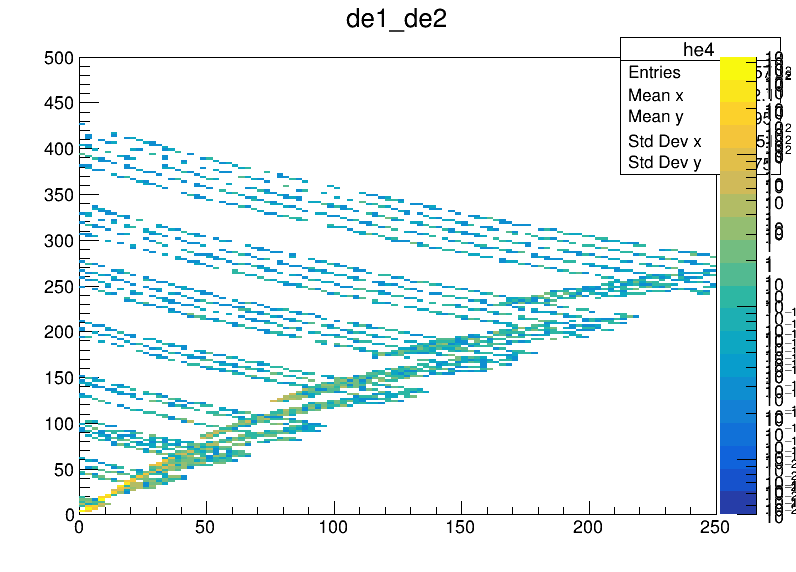

In [11]:
TH2I *he4 = new TH2I("he4", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *he6 = new TH2I("he6", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *he8 = new TH2I("he8", "de1_de2", 100, 0, 250, 200, 0, 500);

    TH2I *n12 = new TH2I("n12", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *n13 = new TH2I("n13", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *n14 = new TH2I("n14", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *n15 = new TH2I("n15", "de1_de2", 100, 0, 250, 200, 0, 500);

    TH2I *c11 = new TH2I("c11", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *c12 = new TH2I("c12", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *c13 = new TH2I("c13", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *c14 = new TH2I("c14", "de1_de2", 100, 0, 250, 200, 0, 500);

    TH2I *b10 = new TH2I("b10", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *b11 = new TH2I("b11", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *b12 = new TH2I("b12", "de1_de2", 100, 0, 250, 200, 0, 500);

    TH2I *be7 = new TH2I("be7", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *be9 = new TH2I("be9", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *be10 = new TH2I("be10", "de1_de2", 100, 0, 250, 200, 0, 500);

    TH2I *li6 = new TH2I("li6", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *li7 = new TH2I("li7", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *li8 = new TH2I("li8", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *li9 = new TH2I("li9", "de1_de2", 100, 0, 250, 200, 0, 500);

    TH2I *h1 = new TH2I("h1", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *h2 = new TH2I("h2", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *h3 = new TH2I("h3", "de1_de2", 100, 0, 250, 200, 0, 500);

    TH2I *o14 = new TH2I("o14", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *o15 = new TH2I("o15", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *o16 = new TH2I("o16", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *o17 = new TH2I("o17", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *o18 = new TH2I("o18", "de1_de2", 100, 0, 250, 200, 0, 500);


    TCanvas *tele = new TCanvas("tele", " ", 800, 600);
    ele_family("he", 4, he4, 0)->Draw("colz");
    ele_family("he", 6, he6, 0)->Draw("same colz");
    ele_family("he", 8, he8, 0)->Draw("same colz");
  
    ele_family("o", 14, o14, 0)->Draw("same colz");
    ele_family("o", 15, o15, 0)->Draw("same colz");
    ele_family("o", 16, o16, 0)->Draw("same colz");
    ele_family("o", 17, o17, 0)->Draw("same colz");
    ele_family("o", 18, o18, 0)->Draw("same colz");

    ele_family("n", 12, n12, 0)->Draw("same colz");
    ele_family("n", 13, n13, 0)->Draw("same colz");
    ele_family("n", 14, n14, 0)->Draw("same colz");
    ele_family("n", 15, n15, 0)->Draw("same colz");

    ele_family("c", 11, c11, 0)->Draw("same colz");
    ele_family("c", 12, c12, 0)->Draw("same colz");
    ele_family("c", 13, c13, 0)->Draw("same colz");
    ele_family("c", 14, c14, 0)->Draw("same colz");

    ele_family("b", 10, b10, 0)->Draw("same colz");
    ele_family("b", 11, b11, 0)->Draw("same colz");
    ele_family("b", 12, b12, 0)->Draw("same colz");

    ele_family("be", 7, be7, 0)->Draw("same colz");
    ele_family("be", 9, be9, 0)->Draw("same colz");
    ele_family("be", 10, be10, 0)->Draw("same colz");

    ele_family("li", 6, li6, 0)->Draw("same colz");
    ele_family("li", 7, li7, 0)->Draw("same colz");
    ele_family("li", 8, li8, 0)->Draw("same colz");
    ele_family("li", 9, li9, 0)->Draw("same colz");

    ele_family("p", 1, h1, 0)->Draw("same colz");
    ele_family("p", 2, h2, 0)->Draw("same colz");
    ele_family("p", 3, h3, 0)->Draw("same colz");

    tele->SetLogz();
    tele->Draw();

<font size =4>上图即为de2-de1的TH2图，可以明显看到各个同位素形成的谱线。

## 绘制de2-de3的TH2图

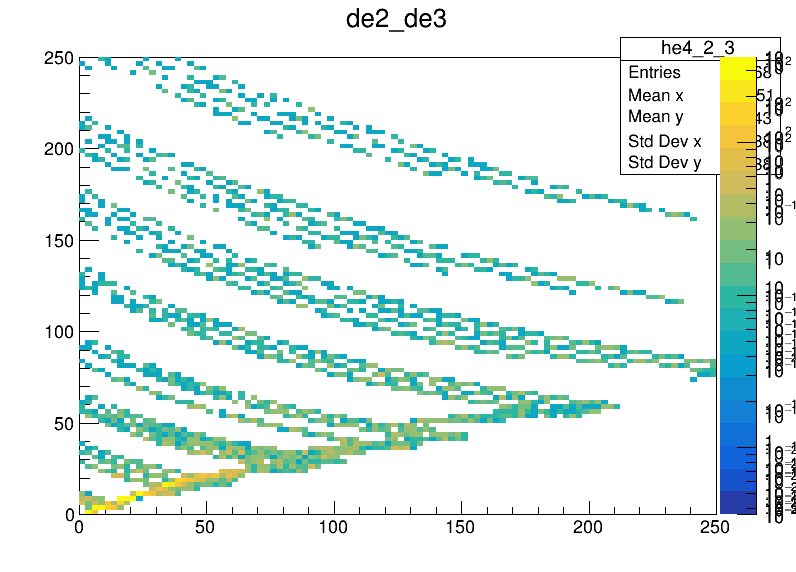

In [12]:
tele->Clear();

TH2I *he4_2_3 = new TH2I("he4_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *he6_2_3 = new TH2I("he6_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *he8_2_3 = new TH2I("he8_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);

    TH2I *n12_2_3 = new TH2I("n12_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *n13_2_3 = new TH2I("n13_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *n14_2_3 = new TH2I("n14_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *n15_2_3 = new TH2I("n15_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);

    TH2I *c11_2_3 = new TH2I("c11_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *c12_2_3 = new TH2I("c12_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *c13_2_3 = new TH2I("c13_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *c14_2_3 = new TH2I("c14_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);

    TH2I *b10_2_3 = new TH2I("b10_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *b11_2_3 = new TH2I("b11_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *b12_2_3 = new TH2I("b12_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);

    TH2I *be7_2_3 = new TH2I("be7_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *be9_2_3 = new TH2I("be9_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *be10_2_3 = new TH2I("be10_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);

    TH2I *li6_2_3 = new TH2I("li6_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *li7_2_3 = new TH2I("li7_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *li8_2_3 = new TH2I("li8_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *li9_2_3 = new TH2I("li9_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);

    TH2I *h1_2_3 = new TH2I("h1_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *h2_2_3 = new TH2I("h2_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *h3_2_3 = new TH2I("h3_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);

    TH2I *o14_2_3 = new TH2I("o14_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *o15_2_3 = new TH2I("o15_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *o16_2_3 = new TH2I("o16_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *o17_2_3 = new TH2I("o17_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);
    TH2I *o18_2_3 = new TH2I("o18_2_3", "de2_de3", 100, 0, 250, 100, 0, 250);

    ele_family("he", 4, he4_2_3, 1)->Draw("colz");
    ele_family("he", 6, he6_2_3, 1)->Draw("same colz");
    ele_family("he", 8, he8_2_3, 1)->Draw("same colz");

    ele_family("o", 14, o14_2_3, 1)->Draw("same colz");
    ele_family("o", 15, o15_2_3, 1)->Draw("same colz");
    ele_family("o", 16, o16_2_3, 1)->Draw("same colz");
    ele_family("o", 17, o17_2_3, 1)->Draw("same colz");
    ele_family("o", 18, o18_2_3, 1)->Draw("same colz");

    ele_family("n", 12, n12_2_3, 1)->Draw("same colz");
    ele_family("n", 13, n13_2_3, 1)->Draw("same colz");
    ele_family("n", 14, n14_2_3, 1)->Draw("same colz");
    ele_family("n", 15, n15_2_3, 1)->Draw("same colz");

    ele_family("c", 11, c11_2_3, 1)->Draw("same colz");
    ele_family("c", 12, c12_2_3, 1)->Draw("same colz");
    ele_family("c", 13, c13_2_3, 1)->Draw("same colz");
    ele_family("c", 14, c14_2_3, 1)->Draw("same colz");

    ele_family("b", 10, b10_2_3, 1)->Draw("same colz");
    ele_family("b", 11, b11_2_3, 1)->Draw("same colz");
    ele_family("b", 12, b12_2_3, 1)->Draw("same colz");

    ele_family("be", 7, be7_2_3, 1)->Draw("same colz");
    ele_family("be", 9, be9_2_3, 1)->Draw("same colz");
    ele_family("be", 10, be10_2_3, 1)->Draw("same colz");

    ele_family("li", 6, li6_2_3, 1)->Draw("same colz");
    ele_family("li", 7, li7_2_3, 1)->Draw("same colz");
    ele_family("li", 8, li8_2_3, 1)->Draw("same colz");
    ele_family("li", 9, li9_2_3, 1)->Draw("same colz");

    ele_family("p", 1, h1_2_3, 1)->Draw("same colz");
    ele_family("p", 2, h2_2_3, 1)->Draw("same colz");
    ele_family("p", 3, h3_2_3, 1)->Draw("same colz");
    
    tele->SetLogz();
    tele->Draw();

<font size = 4>上图即为de2-de3的TH2图，可以看到清晰的谱线结构存在。

## 绘制de1-de1+de2+de3的TH2图

In [ ]:
tele->Clear();

TH2I *he4_tot = new TH2I("he4_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *he6_tot = new TH2I("he6_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *he8_tot = new TH2I("he8_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);

    TH2I *o14_tot = new TH2I("o14_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *o15_tot = new TH2I("o15_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *o16_tot = new TH2I("o16_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *o17_tot = new TH2I("o17_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *o18_tot = new TH2I("o18_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);


    TH2I *n12_tot = new TH2I("n12_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *n13_tot = new TH2I("n13_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *n14_tot = new TH2I("n14_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *n15_tot = new TH2I("n15_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);

    TH2I *c11_tot = new TH2I("c11_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *c12_tot = new TH2I("c12_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *c13_tot = new TH2I("c13_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *c14_tot = new TH2I("c14_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);

    TH2I *b10_tot = new TH2I("b10_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *b11_tot = new TH2I("b11_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *b12_tot = new TH2I("b12_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);

    TH2I *be7_tot = new TH2I("be7_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *be9_tot = new TH2I("be9_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *be10_tot = new TH2I("be10_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);

    TH2I *li6_tot = new TH2I("li6_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *li7_tot = new TH2I("li7_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *li8_tot = new TH2I("li8_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *li9_tot = new TH2I("li9_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);

    TH2I *h1_tot = new TH2I("h1_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *h2_tot = new TH2I("h2_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);
    TH2I *h3_tot = new TH2I("h3_tot", "de1-de1+de2+de3", 300, 0, 600, 300, 0, 600);

    ele_family("he", 4, he4_tot, 2)->Draw("colz");
    ele_family("he", 6, he6_tot, 2)->Draw("same colz");
    ele_family("he", 8, he8_tot, 2)->Draw("same colz");

    ele_family("n", 12, n12_tot, 2)->Draw("same colz");
    ele_family("n", 13, n13_tot, 2)->Draw("same colz");
    ele_family("n", 14, n14_tot, 2)->Draw("same colz");
    ele_family("n", 15, n15_tot, 2)->Draw("same colz");

    ele_family("c", 11, c11_tot, 2)->Draw("same colz");
    ele_family("c", 12, c12_tot, 2)->Draw("same colz");
    ele_family("c", 13, c13_tot, 2)->Draw("same colz");
    ele_family("c", 14, c14_tot, 2)->Draw("same colz");

    ele_family("b", 10, b10_tot, 2)->Draw("same colz");
    ele_family("b", 11, b11_tot, 2)->Draw("same colz");
    ele_family("b", 12, b12_tot, 2)->Draw("same colz");

    ele_family("be", 7, be7_tot, 2)->Draw("same colz");
    ele_family("be", 9, be9_tot, 2)->Draw("same colz");
    ele_family("be", 10, be10_tot, 2)->Draw("same colz");

    ele_family("li", 6, li6_tot, 2)->Draw("same colz");
    ele_family("li", 7, li7_tot, 2)->Draw("same colz");
    ele_family("li", 8, li8_tot, 2)->Draw("same colz");
    ele_family("li", 9, li9_tot, 2)->Draw("same colz");

    ele_family("p", 1, h1_tot, 2)->Draw("same colz");
    ele_family("p", 2, h2_tot, 2)->Draw("same colz");
    ele_family("p", 3, h3_tot, 2)->Draw("same colz");

    ele_family("o", 14, o14_tot, 2)->Draw("same colz");
    ele_family("o", 15, o15_tot, 2)->Draw("same colz");
    ele_family("o", 16, o16_tot, 2)->Draw("same colz");
    ele_family("o", 17, o17_tot, 2)->Draw("same colz");
    ele_family("o", 18, o18_tot, 2)->Draw("same colz");

    tele->SetLogz();
    tele->Draw();

<font size =4>此图为de1-de1+de2+de3的对比图，可以看到很清晰的谱系，他们就代表了各个同位素所属元素的谱系。

# 以下对de1-de2的弯折问题进行讨论（以N的同位素为例）

In [ ]:
tele->Clear();
tele->Divide(2,1);
TH2I *n12_t = new TH2I("n12_t", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *n13_t = new TH2I("n13_t", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *n14_t = new TH2I("n14_t", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *n15_t = new TH2I("n15_t", "de1_de2", 100, 0, 250, 200, 0, 500);
tele->cd(1);
    ele_family("n", 12, n12_t, 0)->Draw("colz");
    ele_family("n", 13, n13_t, 0)->Draw("same colz");
    ele_family("n", 14, n14_t, 0)->Draw("same colz");
    ele_family("n", 15, n15_t, 0)->Draw("same colz");

TH2I *n12_0 = new TH2I("n12_0", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *n13_0 = new TH2I("n13_0", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *n14_0 = new TH2I("n14_0", "de1_de2", 100, 0, 250, 200, 0, 500);
    TH2I *n15_0 = new TH2I("n15_0", "de1_de2", 100, 0, 250, 200, 0, 500);

tele->cd(2);
    ele_family("n", 12, n12_0, 3)->Draw("colz");
    ele_family("n", 13, n13_0, 3)->Draw("same colz");
    ele_family("n", 14, n14_0, 3)->Draw("same colz");
    ele_family("n", 15, n15_0, 3)->Draw("same colz");

gPad->SetLogz();
tele->Draw();


<font size =4>
对此进行解释：首先可以注意到，右图的左侧出现了一条明显的黄线，这是由于能量全部沉积在第一个探测器导致的，可以不用理会。其次可以看到，右侧图的弯折明显的消失了。这是在de3==0的条件下出现的结果，也就是说，能量完全沉积在第二个探测器时，曲线的弯折就会消失。由x-E曲线可以得知，随着能量减小，单位距离损失的能量反而增多，这是因为曲线斜率的变化。如果粒子穿过第一个探测器将能量完全沉积在第二个探测器，那么第二个探测器的能损加上第一个探测器的能损就是总能量，此时总能量越小那么第一个探测器的能损反而越高，此时就会出现右图所示的下降曲线；如果粒子仍能穿过第二个探测器，那么第二个探测器中的也是部分能损，这时第一个探测器与第二个探测器中的能损几乎是成正比关系，因为这两段dx在x-E曲线上是紧紧挨着的，所以具有相同变化。


# 补充
<font size = 4>
用这种方法做出的程序，画图程序十分冗长，有一个好的办法是将所有同位素的相关物理量存入root文件，这样会大大简化画图程序。然而这就会导致产生root文件的函数本身较长，这是因为有大量同位素而难以写出一个循环将其全部包含。但是我认为这个问题在实际实验中不会出现，因为实验中会将所有物理量直接存入root文件，然后直接读取即可。